## PBCV analysis from LL34

In [124]:
%pylab inline
import pickle, os
import condor, spimage, h5py
import scipy.stats
import scipy.optimize
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Populating the interactive namespace from numpy and matplotlib


In [125]:
gaussian = lambda x,A,mu,s: A * np.exp(-((mu-x)**2 /(2*s**2)))

## Read data

In [167]:
run = 100
Nmax = -1
chisquared_max = 10
if run == 98:
    intensity_min = 5e4 # run 98 
    intensity_max = 2e5 # run 98
if run == 100:
    intensity_min = 5e3 # run 100
    intensity_max = 2e4 # run 100
davinci_mount = "/Users/benedikt/davinci"
data_folder = "/scratch/fhgfs/xray/amol3416/"
with h5py.File("%s%s/sizing/amol3416_r%04i_sizing.h5" % (davinci_mount, data_folder, run), "r") as f:
    diameter_nm = f['entry_1/sizing/diameter'][:Nmax] * 1e9
    intensity   = f['entry_1/sizing/intensity'][:Nmax]
    nmeanerror  = f['entry_1/sizing/nmeanerror'][:Nmax]
    chisquared  = f['entry_1/sizing/chisquared'][:Nmax]
    checking    = f['entry_1/sizing/checking'][:Nmax]
with h5py.File("%s%s/pbcv/phasing_threshold/amol3416_r%04i_phasing.h5" % (davinci_mount, data_folder, run), "r") as f:
    support_area = f['entry_1/phasing/support_area_nm2'][:Nmax]
    support_largest = f['entry_1/phasing/support_largest_nm'][:Nmax]

## Plotting error metrics to evaluate the size fitting results

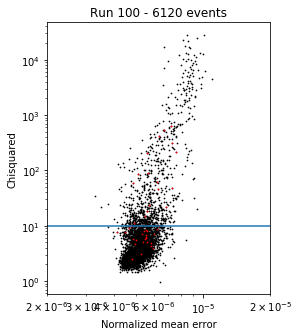

In [168]:
plt.figure(figsize=(4,5))
plt.title('Run %d - %d events' %(run, nmeanerror.size))
plt.scatter(nmeanerror, chisquared, marker='.', color='k', s=2)
plt.scatter(nmeanerror[checking==True], chisquared[checking==True], marker='.', color='r', s=2)
plt.xlim(2e-6,2e-5)
plt.semilogy()
plt.semilogx()
plt.axhline(chisquared_max)
plt.xlabel('Normalized mean error')
plt.ylabel('Chisquared')
plt.show()

## Selecting valid events based on thresholding the chisquared metric

In [169]:
valid = (chisquared < chisquared_max)

## Plotting size vs. intensity histogram

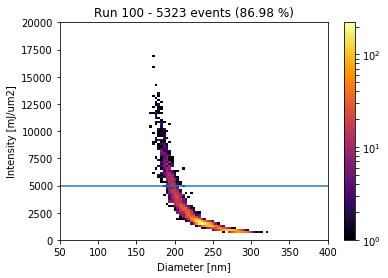

In [170]:
plt.figure()
plt.title('Run %d - %d events (%.2f %%)' %(run, valid.sum(), 100*valid.sum()/ float(nmeanerror.size)))
plt.hist2d(diameter_nm[valid], intensity[valid], bins=(np.linspace(50,400,100), np.linspace(1e1,intensity_max,100)),
          cmap='inferno', norm=colors.LogNorm(vmin=1))
plt.xlabel('Diameter [nm]')
plt.ylabel('Intensity [mJ/um2]')
plt.axhline(intensity_min)
plt.colorbar()
plt.show()

## Selecting high intensity to avoid bias

In [151]:
selected = valid & (intensity > intensity_min)

## Plotting the size distributions

Stats: mean = 145.65, sigma = 5.03


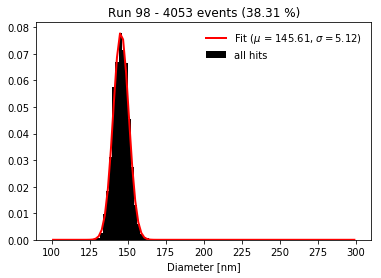

In [152]:
plt.figure()
plt.title('Run %d - %d events (%.2f %%)' %(run, selected.sum(), 100*selected.sum()/ float(nmeanerror.size)))
n,bins, g = plt.hist(diameter_nm[selected], range=(100,300), bins=100, histtype='bar', color='k', 
         stacked=True, lw=0, label='all hits', normed=True)
xbins = (bins[1:] + bins[:-1]) / 2.
p0 = np.array([1., diameter_nm[selected].mean(), diameter_nm[selected].std()])
popt, pcov  = scipy.optimize.curve_fit(gaussian, xbins, n, p0=p0)
print "Stats: mean = %.2f, sigma = %.2f" %(diameter_nm[selected].mean(), diameter_nm[selected].std())
plt.plot(xbins, gaussian(xbins, popt[0], popt[1], popt[2]), 
         label=r'Fit ($\mu$ = %.2f, $\sigma=%.2f$)' %(popt[1], popt[2]), color='r', lw=2)
plt.legend(frameon=False)
plt.xlabel('Diameter [nm]')
plt.show()

## Calculate size based on support retrieval

In [153]:
diameter_nm_support = np.sqrt(support_area)
diameter_nm_largest = support_largest
(mu_support, sigma_support) = scipy.stats.norm.fit(diameter_nm_support)
(mu_largest, sigma_largest) = scipy.stats.norm.fit(diameter_nm_largest)

Stats: mean = 128.48, sigma = 7.79


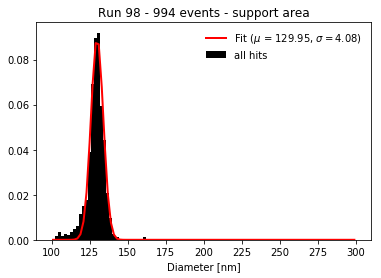

In [154]:
plt.figure()
plt.title('Run %d - %d events - support area' %(run, support_area.size))
n,bins, g = plt.hist(diameter_nm_support, range=(100,300), bins=100, histtype='bar', color='k', 
                     stacked=True, lw=0, label='all hits', normed=True)
xbins = (bins[1:] + bins[:-1]) / 2.
p0 = np.array([1., diameter_nm_support.mean(), diameter_nm_support.std()])
popt, pcov  = scipy.optimize.curve_fit(gaussian, xbins, n, p0=p0)
print "Stats: mean = %.2f, sigma = %.2f" %(diameter_nm_support.mean(), diameter_nm_support.std())
plt.plot(xbins, gaussian(xbins, popt[0], popt[1], popt[2]), 
         label=r'Fit ($\mu$ = %.2f, $\sigma=%.2f$)' %(popt[1], popt[2]), color='r', lw=2)
plt.legend(frameon=False)
plt.xlabel('Diameter [nm]')
plt.show()

Stats: mean = 152.38, sigma = 10.24


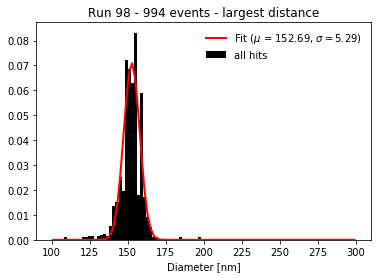

In [155]:
plt.figure()
plt.title('Run %d - %d events - largest distance' %(run, support_largest.size))
n,bins, g = plt.hist(diameter_nm_largest, range=(100,300), bins=100, histtype='bar', color='k', 
                     stacked=True, lw=0, label='all hits', normed=True)
xbins = (bins[1:] + bins[:-1]) / 2.
p0 = np.array([1., diameter_nm_largest.mean(), diameter_nm_largest.std()])
popt, pcov  = scipy.optimize.curve_fit(gaussian, xbins, n, p0=p0)
print "Stats: mean = %.2f, sigma = %.2f" %(diameter_nm_largest.mean(), diameter_nm_largest.std())
plt.plot(xbins, gaussian(xbins, popt[0], popt[1], popt[2]), 
         label=r'Fit ($\mu$ = %.2f, $\sigma=%.2f$)' %(popt[1], popt[2]), color='r', lw=2)
plt.legend(frameon=False)
plt.xlabel('Diameter [nm]')
plt.show()